라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, concatenate, Input
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 5
model_name = 'Test230725_tank5_lstm_crop720_only-feed'

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [4]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [5]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [6]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [7]:
japonica_training_features_X = japonica_training_data[['feed_quantity']]
japonica_training_features_y = japonica_training_data[['do_mg']]

japonica_validation_features_X = japonica_validation_data[['feed_quantity']]
japonica_validation_features_y = japonica_validation_data[['do_mg']]

In [8]:
japonica_training_features_X_chunks = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_training_features_X_chunks = japonica_training_features_X_chunks.reshape((-1, 720, 1))
japonica_training_features_y_chunks = np.asarray(japonica_training_features_y, dtype=np.float64)
japonica_training_features_y_chunks = japonica_training_features_y_chunks.reshape((-1, 720, 1))

japonica_validation_features_X_chunks = np.asarray(japonica_validation_features_X, dtype=np.float64)
japonica_validation_features_X_chunks = japonica_validation_features_X_chunks.reshape((-1, 720, 1))
japonica_validation_features_y_chunks = np.asarray(japonica_validation_features_y, dtype=np.float64)
japonica_validation_features_y_chunks = japonica_validation_features_y_chunks.reshape((-1, 720, 1))

In [9]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1
nCar: 90 nVar: 720
nCar: 90 nVar: 1
nCar: 90 nVar: 720


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [10]:
# LSTM 모델 생성
model = Sequential()
model.add(LSTM(128, input_shape=(720, 1), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(720, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks, japonica_training_features_y_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_features_X_chunks, japonica_validation_features_y_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

2023-07-25 01:43:46.577368: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 01:43:47.211805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:d5:00.0, compute capability: 8.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 720, 64)           49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 720)               23760     
Total params: 152,144
Trainable params: 152,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


2023-07-25 01:43:48.072564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-07-25 01:43:52.218758: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-25 01:43:53.197646: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 7s 592ms/step - loss: 109.5966 - mae: 10.2960 - r_squared: -32.4559 - val_loss: 109.5224 - val_mae: 10.2923 - val_r_squared: -44.1461
Epoch 2/1000
3/3 [==============================] - 0s 170ms/step - loss: 109.4542 - mae: 10.2891 - r_squared: -31.6050 - val_loss: 109.2181 - val_mae: 10.2775 - val_r_squared: -44.0152
Epoch 3/1000
3/3 [==============================] - 0s 162ms/step - loss: 108.9344 - mae: 10.2635 - r_squared: -31.4327 - val_loss: 107.8282 - val_mae: 10.2093 - val_r_squared: -43.4175
Epoch 4/1000
3/3 [==============================] - 0s 169ms/step - loss: 107.0568 - mae: 10.1716 - r_squared: -31.2487 - val_loss: 105.8781 - val_mae: 10.1126 - val_r_squared: -42.5794
Epoch 5/1000
3/3 [==============================] - 0s 166ms/step - loss: 105.3682 - mae: 10.0874 - r_squared: -29.8217 - val_loss: 104.1678 - val_mae: 10.0273 - val_r_squared: -41.8445
Epoch 6/1000
3/3 [==============================] - 0s 165ms/step - loss: 103.5559 

Epoch 46/1000
3/3 [==============================] - 0s 195ms/step - loss: 35.7763 - mae: 5.6684 - r_squared: -10.4352 - val_loss: 35.1259 - val_mae: 5.6109 - val_r_squared: -12.4962
Epoch 47/1000
3/3 [==============================] - 0s 201ms/step - loss: 34.8295 - mae: 5.5853 - r_squared: -9.7434 - val_loss: 34.2068 - val_mae: 5.5287 - val_r_squared: -12.1132
Epoch 48/1000
3/3 [==============================] - 0s 203ms/step - loss: 33.9282 - mae: 5.5033 - r_squared: -9.6632 - val_loss: 33.3029 - val_mae: 5.4467 - val_r_squared: -11.7370
Epoch 49/1000
3/3 [==============================] - 0s 193ms/step - loss: 33.0285 - mae: 5.4216 - r_squared: -8.3071 - val_loss: 32.4262 - val_mae: 5.3660 - val_r_squared: -11.3725
Epoch 50/1000
3/3 [==============================] - 0s 197ms/step - loss: 32.1554 - mae: 5.3414 - r_squared: -9.1067 - val_loss: 31.5723 - val_mae: 5.2863 - val_r_squared: -11.0179
Epoch 51/1000
3/3 [==============================] - 0s 196ms/step - loss: 31.3117 - mae:

3/3 [==============================] - 0s 167ms/step - loss: 10.8502 - mae: 2.8358 - r_squared: -2.8225 - val_loss: 10.6680 - val_mae: 2.8082 - val_r_squared: -2.5529
Epoch 92/1000
3/3 [==============================] - 0s 173ms/step - loss: 10.5812 - mae: 2.7948 - r_squared: -2.0153 - val_loss: 10.4098 - val_mae: 2.7675 - val_r_squared: -2.4536
Epoch 93/1000
3/3 [==============================] - 0s 173ms/step - loss: 10.3287 - mae: 2.7547 - r_squared: -2.0296 - val_loss: 10.1572 - val_mae: 2.7272 - val_r_squared: -2.3568
Epoch 94/1000
3/3 [==============================] - 0s 149ms/step - loss: 10.0779 - mae: 2.7146 - r_squared: -2.2451 - val_loss: 9.9135 - val_mae: 2.6879 - val_r_squared: -2.2637
Epoch 95/1000
3/3 [==============================] - 0s 145ms/step - loss: 9.8424 - mae: 2.6772 - r_squared: -2.1638 - val_loss: 9.6764 - val_mae: 2.6490 - val_r_squared: -2.1735
Epoch 96/1000
3/3 [==============================] - 0s 169ms/step - loss: 9.6094 - mae: 2.6367 - r_squared: -1.

3/3 [==============================] - 1s 214ms/step - loss: 4.6679 - mae: 1.5911 - r_squared: -0.3249 - val_loss: 4.6301 - val_mae: 1.5805 - val_r_squared: -0.3869
Epoch 137/1000
3/3 [==============================] - 1s 211ms/step - loss: 4.6133 - mae: 1.5760 - r_squared: -0.2984 - val_loss: 4.5806 - val_mae: 1.5662 - val_r_squared: -0.3724
Epoch 138/1000
3/3 [==============================] - 1s 205ms/step - loss: 4.5645 - mae: 1.5615 - r_squared: -0.3124 - val_loss: 4.5328 - val_mae: 1.5524 - val_r_squared: -0.3587
Epoch 139/1000
3/3 [==============================] - 1s 205ms/step - loss: 4.5165 - mae: 1.5481 - r_squared: -0.3055 - val_loss: 4.4869 - val_mae: 1.5391 - val_r_squared: -0.3456
Epoch 140/1000
3/3 [==============================] - 0s 203ms/step - loss: 4.4700 - mae: 1.5350 - r_squared: -0.2641 - val_loss: 4.4427 - val_mae: 1.5263 - val_r_squared: -0.3333
Epoch 141/1000
3/3 [==============================] - 0s 194ms/step - loss: 4.4280 - mae: 1.5222 - r_squared: -0.26

3/3 [==============================] - 0s 166ms/step - loss: 3.6301 - mae: 1.3165 - r_squared: -0.0165 - val_loss: 3.6250 - val_mae: 1.3159 - val_r_squared: -0.1693
Epoch 182/1000
3/3 [==============================] - 0s 161ms/step - loss: 3.6227 - mae: 1.3155 - r_squared: -0.0354 - val_loss: 3.6191 - val_mae: 1.3151 - val_r_squared: -0.1694
Epoch 183/1000
3/3 [==============================] - 0s 171ms/step - loss: 3.6177 - mae: 1.3151 - r_squared: -0.0024 - val_loss: 3.6131 - val_mae: 1.3144 - val_r_squared: -0.1697
Epoch 184/1000
3/3 [==============================] - 1s 206ms/step - loss: 3.6117 - mae: 1.3143 - r_squared: -0.0082 - val_loss: 3.6075 - val_mae: 1.3138 - val_r_squared: -0.1699
Epoch 185/1000
3/3 [==============================] - 0s 193ms/step - loss: 3.6072 - mae: 1.3137 - r_squared: -0.0262 - val_loss: 3.6020 - val_mae: 1.3133 - val_r_squared: -0.1702
Epoch 186/1000
3/3 [==============================] - 0s 199ms/step - loss: 3.6007 - mae: 1.3131 - r_squared: -0.00

Epoch 227/1000
3/3 [==============================] - 0s 172ms/step - loss: 3.5148 - mae: 1.3190 - r_squared: -0.0073 - val_loss: 3.5139 - val_mae: 1.3191 - val_r_squared: -0.2014
Epoch 228/1000
3/3 [==============================] - 0s 163ms/step - loss: 3.5138 - mae: 1.3192 - r_squared: 1.7991e-04 - val_loss: 3.5136 - val_mae: 1.3193 - val_r_squared: -0.2019
Epoch 229/1000
3/3 [==============================] - 0s 172ms/step - loss: 3.5136 - mae: 1.3195 - r_squared: 0.0116 - val_loss: 3.5131 - val_mae: 1.3196 - val_r_squared: -0.2025
Epoch 230/1000
3/3 [==============================] - 0s 170ms/step - loss: 3.5131 - mae: 1.3197 - r_squared: 0.0057 - val_loss: 3.5128 - val_mae: 1.3198 - val_r_squared: -0.2030
Epoch 231/1000
3/3 [==============================] - 0s 166ms/step - loss: 3.5127 - mae: 1.3199 - r_squared: 0.0026 - val_loss: 3.5124 - val_mae: 1.3201 - val_r_squared: -0.2035
Epoch 232/1000
3/3 [==============================] - 0s 166ms/step - loss: 3.5122 - mae: 1.3201 - r

Epoch 273/1000
3/3 [==============================] - 1s 205ms/step - loss: 3.5070 - mae: 1.3274 - r_squared: 0.0166 - val_loss: 3.5069 - val_mae: 1.3274 - val_r_squared: -0.2181

Epoch 00273: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 274/1000
3/3 [==============================] - 0s 201ms/step - loss: 3.5069 - mae: 1.3274 - r_squared: 0.0062 - val_loss: 3.5069 - val_mae: 1.3275 - val_r_squared: -0.2181
Epoch 275/1000
3/3 [==============================] - 0s 197ms/step - loss: 3.5069 - mae: 1.3275 - r_squared: -0.0055 - val_loss: 3.5069 - val_mae: 1.3275 - val_r_squared: -0.2181
Epoch 276/1000
3/3 [==============================] - 0s 199ms/step - loss: 3.5069 - mae: 1.3275 - r_squared: 0.0179 - val_loss: 3.5069 - val_mae: 1.3275 - val_r_squared: -0.2181

Epoch 00276: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 277/1000
3/3 [==============================] - 0s 198ms/step - loss: 3.5069 - mae: 1.3275 - r_squared: 0.0251 - 

모델 평가

In [11]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [12]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-3.41002718e-02  7.87867159e-02  6.86895028e-02  6.33969605e-02
  -1.95567356e-03  7.30388686e-02 -8.96219630e-03  1.12970434e-02
  -7.57982135e-02 -3.93956006e-02  6.13400117e-02 -2.09964011e-02
  -9.41933170e-02  1.01223297e-01  8.60599335e-03 -1.86122712e-02
   4.66229831e-05 -7.48058483e-02 -6.09391853e-02 -1.04292013e-01
   3.56346071e-02 -2.87605617e-02  3.04453559e-02 -6.03786744e-02
  -9.24952477e-02 -2.45822202e-02  8.36875290e-03 -8.95599276e-02
   1.07611511e-02  5.34862913e-02 -5.28789498e-02 -8.21516141e-02
  -7.33885914e-02  1.05996057e-01 -1.07705496e-01 -3.67655940e-02
  -5.78218978e-03 -8.20815340e-02 -8.13516602e-02 -8.64793360e-02
   2.45410185e-02  4.59171087e-02  5.50722517e-02  1.22059723e-02
  -1.27844233e-02 -4.76582199e-02  5.96200190e-02 -4.95603075e-03
   1.03853047e-01 -8.28901604e-02  9.35716331e-02  2.03734785e-02
  -2.51528304e-02  9.73171275e-03  2.37369221e-02  7.31145665e-02
   8.92620385e-02  8.60868320e-02 -7.38272667e-02  8.58692359e-03
   7.86734

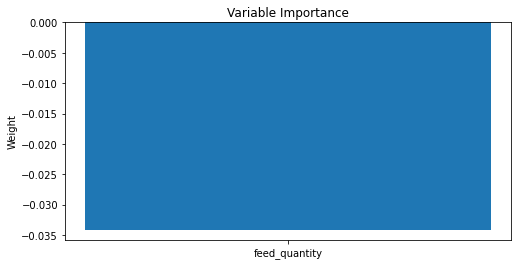

In [13]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(1), weights[:, 0])
ax.set_xticks(range(1))
ax.set_xticklabels(['feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [14]:
japonica_validation_features_X

,feed_quantity
mea_dt,
2021-07-21 00:00:00,0.0
2021-07-21 00:01:00,0.0
2021-07-21 00:02:00,0.0
2021-07-21 00:03:00,0.0
2021-07-21 00:04:00,0.0
...,...
2021-09-08 23:55:00,0.0
2021-09-08 23:56:00,0.0
2021-09-08 23:57:00,0.0


In [15]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 90 nVar: 1


In [16]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64800 nVar: 1
nCar: 90 nVar: 720


64800


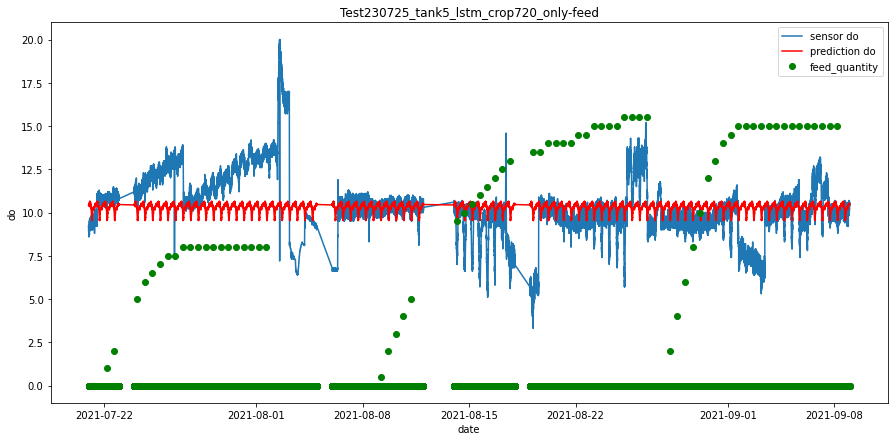

3/3 [==============================] - 1s 30ms/step - loss: 3.5069 - mae: 1.3275 - r_squared: -0.2181
MSE // MAE // R-squared  [3.5069007873535156, 1.3274868726730347, -0.2181416004896164]


In [17]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [18]:
X = japonica_validation_data.loc['2021-08-02 00:00':'2021-08-03 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 1


In [19]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2880 nVar: 1
nCar: 4 nVar: 720


2880


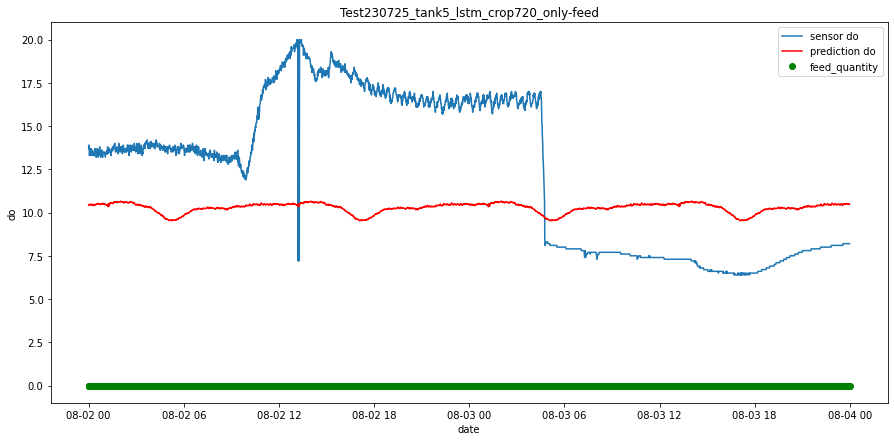

1/1 [==============================] - 0s 61ms/step - loss: 23.8662 - mae: 4.4421 - r_squared: -0.2249
MSE // MAE // R-squared  [23.866241455078125, 4.442098140716553, -0.22491860389709473]


In [20]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [21]:
X = japonica_validation_data.loc['2021-08-01 00:00':'2021-08-08 23:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14 nVar: 1


In [22]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 10080 nVar: 1
nCar: 14 nVar: 720


10080


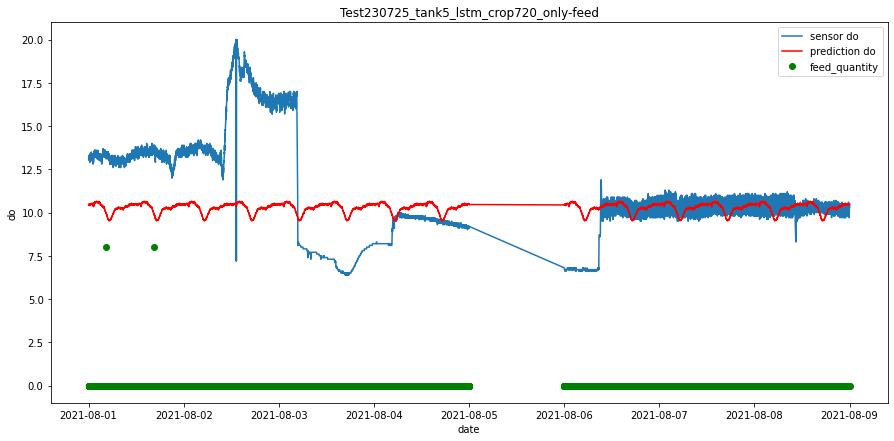

1/1 [==============================] - 0s 70ms/step - loss: 9.0595 - mae: 2.1695 - r_squared: -0.0574
MSE // MAE // R-squared  [9.059487342834473, 2.169480085372925, -0.05736196041107178]


In [23]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

In [24]:
X = japonica_validation_data.loc['2021-08-03 00:00':'2021-08-03 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1 nVar: 1


In [25]:
y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 1 nVar: 720


720


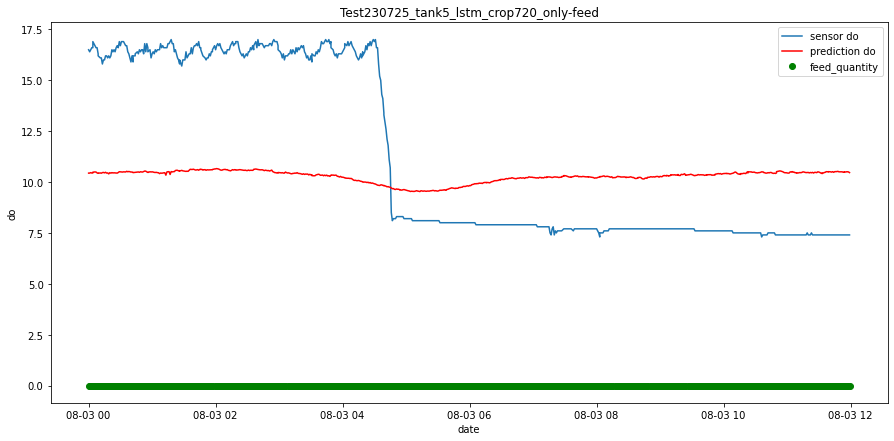

1/1 [==============================] - 0s 70ms/step - loss: 18.0610 - mae: 3.8508 - r_squared: 0.0035
MSE // MAE // R-squared  [18.06104278564453, 3.8507680892944336, 0.0034900903701782227]


In [26]:
grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)

nCar: 1 nVar: 1
nCar: 720 nVar: 1
nCar: 1 nVar: 720
720


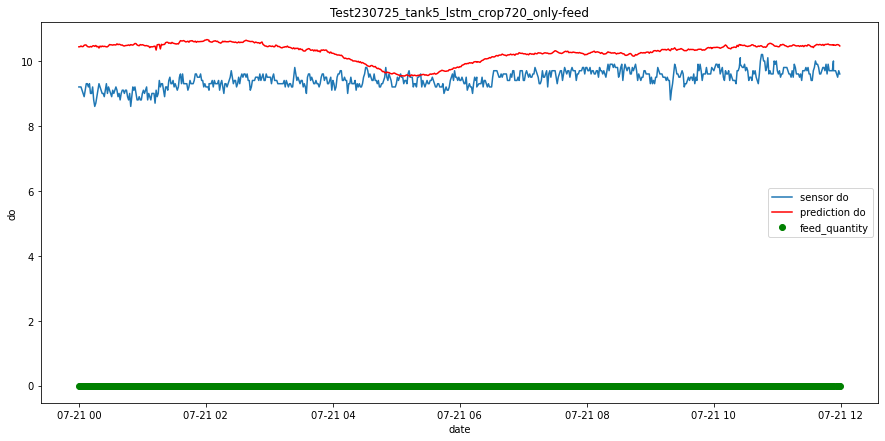

1/1 [==============================] - 0s 66ms/step - loss: 0.8283 - mae: 0.8277 - r_squared: -11.4306
MSE // MAE // R-squared  [0.8283267617225647, 0.8276607990264893, -11.430597305297852]


In [27]:
X = japonica_validation_data.loc['2021-07-21 00:00':'2021-07-21 11:59']
X_test = X[['feed_quantity']]

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 720, 1))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

y_test = X[['do_mg']]


y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 720, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

grapeNEva(model, X_test_reshape, y_test, X_test[['feed_quantity']], y_test_reshape)